In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
#crate paths for csv files
CURR_DIR = os.getcwd()
print(CURR_DIR)
zlecenia_path = os.path.join(CURR_DIR, 'Zlecenia.csv')
godziny_path = os.path.join(CURR_DIR, 'Godziny.csv')

C:\Users\ksobo\Desktop\DS_final_project


In [3]:
#Zaciagniecie baz danych
obciazenie_df = pd.read_csv(zlecenia_path, sep=';')
godziny_df = pd.read_csv(godziny_path, sep=';')

In [4]:
#Ekstrakcja danych i organizacja danych - pozostawienie tylko kolumn wymaganych, pozostawienie tylko projektów "w toku"
obciazenie_df1 = obciazenie_df.drop(columns=['work_preparation_Plan','work_preparation_done'], axis=1)
obciazenie_df2 = obciazenie_df1.loc[obciazenie_df1['Active'].isin(['Active'])]
godziny_df = godziny_df[['No','Wszystkie.technol','Wszystkie.wykonane']]

In [5]:
#Left join po No z godzinami
obciazenie_df2 = pd.merge(obciazenie_df2, godziny_df, how='left', on='No')

#wypelnienie NaN zerami
obciazenie_df2['Wszystkie.technol'] = obciazenie_df2['Wszystkie.technol'].fillna(0)
obciazenie_df2['Wszystkie.wykonane'] = obciazenie_df2['Wszystkie.wykonane'].fillna(0)

In [6]:
#Zdefiniowanie tygodnia obecnego
#przyjmujemy obecny jako 202112(tydzień zaciągnięcia danych),
#docelowo może zostać zamieniony funkcją obliczającą jak poniżej
#WPISAĆ FUNKCJĘ!!!!!!!!!

current_week = 202112

In [7]:
#Zmiana terminu rozpoczęcia oraz zakończenia na obecny jeżeli miało mieć ono miejsce w przeszłości
obciazenie_df2.loc[obciazenie_df2['Finnish_week'] < current_week, 'Finnish_week'] = current_week

obciazenie_df2.loc[obciazenie_df2['Pre_fabrication_plan'] < current_week, 'Pre_fabrication_plan'] = current_week

In [8]:
#Zlecenia które nie zostały opracowane wypełnione zostaną wartościami przewidzianymi w prekalkulacji

#A - dziób(wędka)
#Labor rate	130 rbg/1000kg
#Assembling	0,4
#Welding	0,33
#Grindining	0,07
#Else		0,2

#B - belka(środek)
#Labor rate	100 rbg/1000kg
#Assembling	0,3
#Welding	0,4
#Grindining	0,2
#Else		0,1

#C - gniazdo(końcówka)
#Labor rate	120 rbg/1000kg
#Assembling	0,25
#Welding	0,4
#Grindining	0,2
#Else		0,15

obciazenie_df2.loc[obciazenie_df2['Typ'] == 'A', 'Typ'] = 0.13
obciazenie_df2.loc[obciazenie_df2['Typ'] == 'B', 'Typ'] = 0.1
obciazenie_df2.loc[obciazenie_df2['Typ'] == 'C', 'Typ'] = 0.12

# IF Wszystkie technol = NaN -> Weight for 1 * Quantity * Typ

obciazenie_df2.loc[obciazenie_df2['Wszystkie.technol'] == 0, 'Wszystkie.technol'] = obciazenie_df2['Weight_for_1'] * obciazenie_df2['Quantity'] * obciazenie_df2['Typ']

In [9]:
#Obliczenie kolumn - pozostałego czasu na produkcję oraz pozostałych godzin
obciazenie_df2['Weeks_left'] = (obciazenie_df2['Finnish_week']) - (obciazenie_df2['Pre_fabrication_plan'])

#Jeżeli >52 to należy odjąc od wyniku 48 (100 - (ilość tyg w danym roku - def 52))
#Może tak się stać dla projektów na przełomie roku 202206-202146 = 60!
obciazenie_df2.loc[obciazenie_df2['Weeks_left'] > 52, 'Weeks_left'] = obciazenie_df2['Weeks_left'] - 48

#Jeżeli zlecenie jest opóźnione i wynik pozostałego czasu będzie wynosił 0
#to zostanie on doliczony do obecnego tygodnia
obciazenie_df2.loc[obciazenie_df2['Weeks_left'] < 1, 'Weeks_left'] = 1

#funkcja if niestety nie znalazła odpowiedniego zastosowania - loc jest polecany jako dobra praktyka

In [10]:
#Wyliczenie pozostałych godzin pracy
obciazenie_df2['Work_h_left'] = (obciazenie_df2['Wszystkie.technol']) - (obciazenie_df2['Wszystkie.wykonane'])

#Jeżeli zlecenie przekroczyło godziny praca liczona jest w nadgodzinach - przyjmuje się 0 do obciażenia
obciazenie_df2.loc[obciazenie_df2['Work_h_left'] < 0, 'Work_h_left'] = 0

In [11]:
#Podzielenie pozostałej pracy równomiernie na tygodnie
obciazenie_df2['Workload_per_week'] = (obciazenie_df2['Work_h_left']) / (obciazenie_df2['Weeks_left'])
obciazenie_df2['Workload_per_week'].astype(int)

0      0
1      0
2      0
3      7
4     64
      ..
58    40
59    80
60    64
61    80
62    80
Name: Workload_per_week, Length: 63, dtype: int32

In [12]:
#Dodanie obciazenia zarezerwowanego na dany tydzien w zależności od rozpoczecia i zakonczenia danego zlecenia

for i in range (0,14):
    conditions = [
        (obciazenie_df2['Pre_fabrication_plan'] <= current_week+i) & (obciazenie_df2['Finnish_week'] >= current_week+i),
        (obciazenie_df2['Pre_fabrication_plan'] > current_week+i) & (obciazenie_df2['Finnish_week'] < current_week+i)]
    choices = [1, 0]
    obciazenie_df2[current_week+i] = np.select(conditions, choices, default='0')

In [13]:
#Wykonanie tabeli z ostatecznymi wynikami
obciazenie_df3 = obciazenie_df2.iloc[: ,-15:].astype(int)
obciazenie_result = obciazenie_df3.iloc[: ,-14:].multiply(obciazenie_df3['Workload_per_week'], axis="index")
obciazenie_result_df = pd.DataFrame({'Required Manpower': obciazenie_result.sum(axis=0)}).astype(int)

<AxesSubplot:xlabel='Week'>

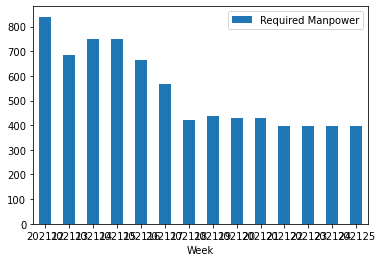

In [14]:
#Wykres podstawa
obciazenie_result_df['Week'] = obciazenie_result_df.index
obciazenie_result_df.plot.bar(x='Week', y='Required Manpower', rot=0)

<BarContainer object of 14 artists>

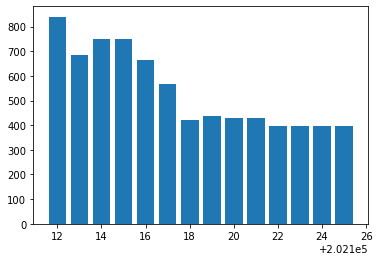

In [15]:
#Wykres plotly
plt.bar(obciazenie_result_df['Week'], obciazenie_result_df['Required Manpower'])